In [2]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models
#import models.simple_depth_morph_models as simple_models
# import models.shallow_depth_morph_models_org as sdmodels

import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

# Section 5.3 MaCormack Model

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

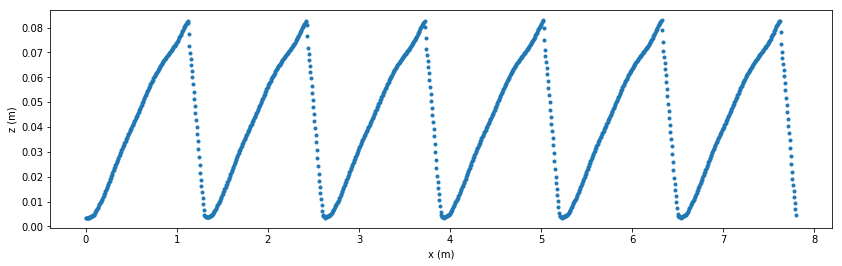

In [3]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## Equilibrium Condtions - 32 cm

In [4]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

# Water Surface Elevation
sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
#simTime = 300*60       # Runtime in seconds
simTime = 300*60       # Runtime in seconds
dt = 5.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 32 cm Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]

$
q_{sb} = \frac{z}{\Delta}q_{sb}^{max}
$

This equation basically says that the bed load is equal to the local local elevation multiplied by the peak bedload. the $q_{sb}^{max}$ is calibrated to match the migration rate of the dune.

 Starting simulation....
Number of time steps: 300.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483164808
Courant number: max 0.06607601698584487, mean0.06601781790957156
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.04286526483164808
Courant number: max 0.06607601698583142, mean0.06604775190819086
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483164808
Courant number: max 0.06607601698582907, mean0.06602094493722854
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526483164808
Courant number: max 0.06607601698583296, mean0.06602842609354509
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526483164808
Courant number: max 0.06607601698583289, mean0.06604508287847662
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526483164808
Courant number: max 0.066076016985833

Text(0, 0.5, 'z (m)')

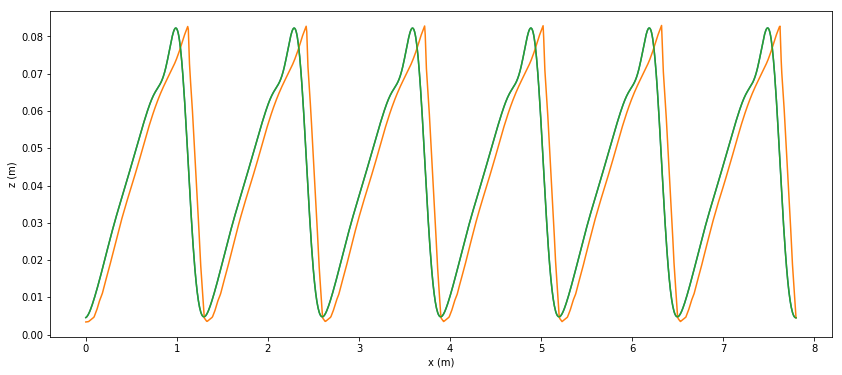

In [10]:
model = parameter_models.ParameterizedMorphologicalModel()

run_name = 'Section_5.3.dune_5_MacCormack_q_{0}_h_{1}_D50_{2}_mr_153'.format('32m','357mm','1.0mm')

dt = 1.0                # Time step size (s)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = exner_models.TVD3rdWenoModel()
morph_model = exner_models.MacCormackModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = True, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)

#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034
qsbmodel = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
model.set_bedload_model(qsbmodel)

%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [11]:
run_name

'Section_5.3.dune_5_MacCormack_q_32m_h_357mm_D50_1.0mm_mr_153'

## Non-equilibrium Case

In [44]:
'''#--------------------------------
#  Initialize the model
#--------------------------------

model = parameter_models.ParameterizedMorphologicalModel()
model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)

dt = 1


#-------------------------
# Set the bedload formula
#-------------------------
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02 #0.2
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

morph_model = exner_models.MacCormackModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = True)


%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


run_name = 'Section_5.3.dune_5_MacCormack_q_{0}_h_{1}_D50_{2}_notsmoothed'.format('20m','237mm','1.0mm')

df = model.get_wave_dataframe()
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
#plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')
'''


#--------------------------------
#  Initialize the model
#--------------------------------

run_name = 'Section_5.3.dune_5_MacCormack_q_20m_h_237mm_D50_1.0mm_v02'

model = parameter_models.ParameterizedMorphologicalModel()
model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)

# !!!!!!!!!!!!!!!!!!!!!!!
dt = 1.0
#-------------------------
# Set the bedload formula
#-------------------------

#qsbmax = 0.000020375
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

morph_model = exner_models.MacCormackModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = True)


%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)

Initalized
 Starting simulation....
Number of time steps: 300.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483128292
Courant number: max 0.0763855412489948, mean0.04111986455907682
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.042865264831303665
Courant number: max 0.0704329232152597, mean0.04138998272675317
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483117702
Courant number: max 0.06621777332949913, mean0.041744806789653775
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526483082121
Courant number: max 0.06303837915342685, mean0.04208514485285231
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526483057132
Courant number: max 0.06048342629150066, mean0.042373951420282135
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526483013872
Courant number: max 0.058

In [45]:
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
run_name

'Section_5.3.dune_5_MacCormack_q_20m_h_237mm_D50_1.0mm_v02'

Text(0.5, 0, 'x (m)')

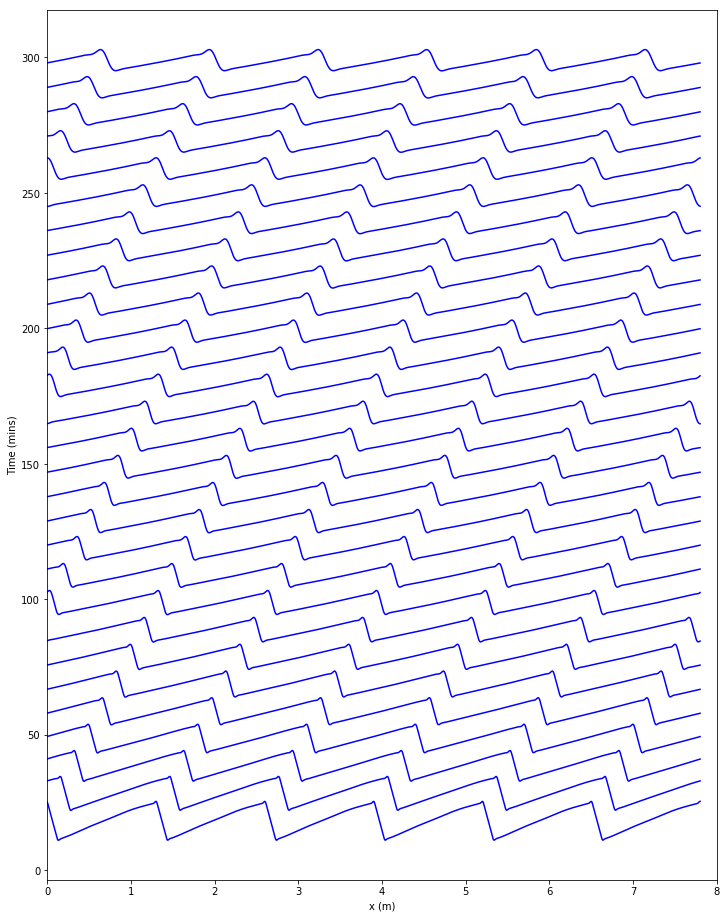

In [46]:
verts = np.load('_output/{0}_verts.npy'.format(run_name))
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)
dt=5
i=0
insert = False
for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')